In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns



def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimensiㄴon
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

from sklearn.model_selection import train_test_split

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

# standardize features using training statistics (keep split as-is)
mu = X_train.mean(axis=(0,1), keepdims=True)
sigma = X_train.std(axis=(0,1), keepdims=True) + 1e-8
X_train = ((X_train - mu) / sigma).astype('float32')
X_val = ((X_val - mu) / sigma).astype('float32')
testX = ((testX - mu) / sigma).astype('float32')
X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape

C:\Users\이예일\AppData\Local\Temp\ipykernel_15732\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_15732\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_15732\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
C:\Users\이예일\AppData\Local\Temp\ipykernel_15732\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


C:\Users\이예일\AppData\Local\Temp\ipykernel_15732\2308141114.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


((5881, 128, 9), (1471, 128, 9), (5881, 6), (1471, 6), (5881, 1), (1471, 1))

In [2]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout

## Stacked GRU classifier
inputs = Input(shape=(n_timesteps, n_features))
x = GRU(128, return_sequences=True)(inputs)
x = Dropout(0.3)(x)
x = GRU(64)(x)
x = Dropout(0.3)(x)
dense = Dense(128, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(dense)
gru_model = Model(inputs, outputs)
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128, 128)       │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,718 (389.52 KB)

 Trainable params: 99,718 (389.52 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping
model_history=gru_model.fit(
    x=X_train,
    y=y_train_one_hot,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-4, restore_best_weights=True)]
)


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.4748 - loss: 1.2892 - val_accuracy: 0.8574 - val_loss: 0.4005
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.8941 - loss: 0.3105 - val_accuracy: 0.9338 - val_loss: 0.1538
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9326 - loss: 0.1762 - val_accuracy: 0.9559 - val_loss: 0.1324
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9461 - loss: 0.1452 - val_accuracy: 0.9491 - val_loss: 0.1154
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9532 - loss: 0.1204 - val_accuracy: 0.9423 - val_loss: 0.1195
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.9522 - loss: 0.1144 - val_accuracy: 0.9576 - val_loss: 0.1174
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9591 - loss: 0.1059 - val_accuracy: 0.9423 - val_loss: 0.1573
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9460 - loss: 0.1360 - val_accuracy: 0.9406 - v

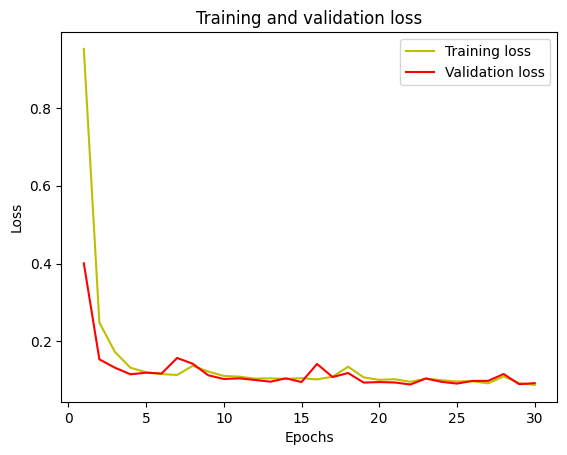

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

loss =model_history.history['loss']
val_loss =model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
     

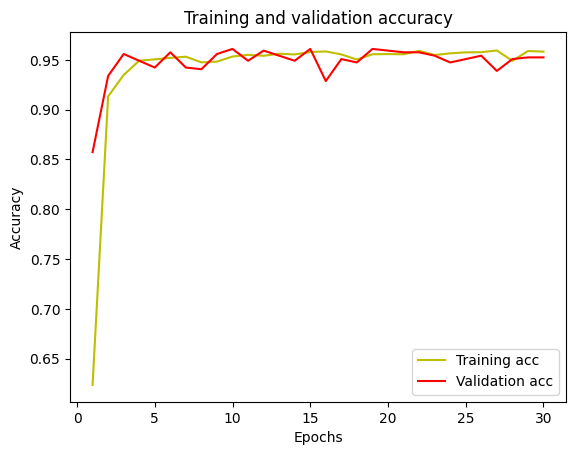

In [6]:
acc =model_history.history['accuracy']
val_acc =model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
[[487   3   6   0   0   0]
 [  9 451  11   0   0   0]
 [  0   9 411   0   0   0]
 [  1  24   0 383  83   0]
 [  5   0   0  92 435   0]
 [  0   9   0   0   0 528]]
0.9144893111638955
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       496
           1       0.91      0.96      0.93       471
           2       0.96      0.98      0.97       420
           3       0.81      0.78      0.79       491
           4       0.84      0.82      0.83       532
           5       1.00      0.98      0.99       537

    accuracy                           0.91      2947
   macro avg       0.91      0.92      0.92      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

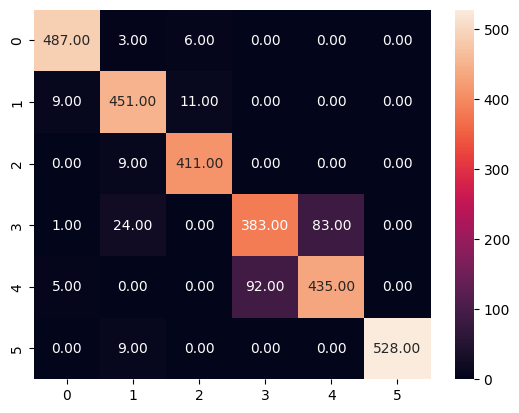

In [7]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
pred=gru_model.predict(testX)
pred=np.argmax(pred, axis=-1)
cm=confusion_matrix(testy,pred)
print(cm)
print(accuracy_score(testy,pred))
print(classification_report(testy,pred))
sns.heatmap(cm, annot=True, fmt = '.2f')
